<a href="https://colab.research.google.com/github/nihalsiddiqui7/Email-Spam-Classifier/blob/main/email_spam_classifier_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install --upgrade scikit-learn xgboost


In [48]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK stopwords if they haven't been downloaded already
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
# Load the dataset from a CSV file
df = pd.read_csv("/content/drive/MyDrive/spam.csv", encoding='latin-1')

In [46]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

In [47]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [44]:
# Define a function to manually preprocess the text messages
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase for uniformity
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove extra whitespace from the start and end
    words = text.split()  # Tokenize the text into words
    stop_words = set(stopwords.words('english'))  # Load stopwords
    stemmer = PorterStemmer()  # Initialize the stemmer
    # Remove stopwords and apply stemming to each word
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [50]:
# Apply the preprocessing function to each message
df['clean_message'] = df['message'].apply(preprocess_text)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_message'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)


In [52]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))

In [53]:
X_train_tfidf = vectorizer.fit_transform(X_train)

In [54]:
X_test_tfidf = vectorizer.transform(X_test)

In [34]:
smote = BorderlineSMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)


In [55]:
print(f"Before SMOTE: {Counter(y_train)}")
print(f"After SMOTE: {Counter(y_train_resampled)}")

Before SMOTE: Counter({0: 3859, 1: 598})
After SMOTE: Counter({0: 3859, 1: 3859})


In [56]:
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

In [57]:
model.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [58]:
y_pred = model.predict(X_test_tfidf)

In [59]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.96      0.87      0.91       149

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



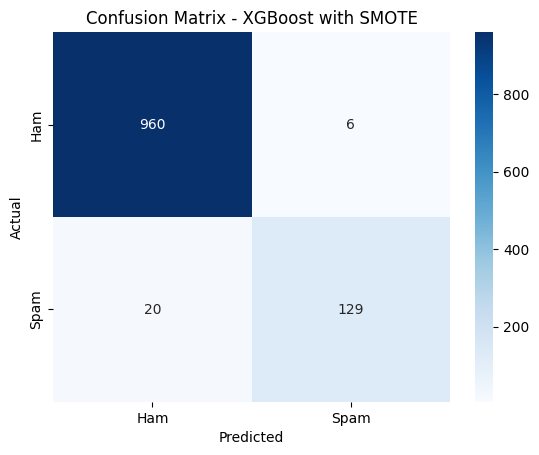

In [60]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost with SMOTE")
plt.show()

In [61]:
def predict_spam(message):
    processed_message = preprocess_text(message)
    vec_message = vectorizer.transform([processed_message])
    prediction = model.predict(vec_message)
    return "Spam" if prediction[0] == 1 else "Ham"


example_message = "hey, where r u? Dinner tonight?"
print("Prediction:", predict_spam(example_message))


Prediction: Ham
